<a href="https://colab.research.google.com/github/hiimjupter/COS40007/blob/main/Portfolio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [211]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [212]:
# Import Necessary Libraries
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

In [213]:
# Step 1: Data Collection and Preprocessing

def load_and_preprocess_data(df, class_label):
    """
    Cleans column names, adds a 'frame' column, handles missing values, and adds class label.

    Parameters:
        df (pd.DataFrame): Original DataFrame.
        class_label (int): Class label to assign.

    Returns:
        pd.DataFrame: Preprocessed DataFrame.
    """
    # Clean column names
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.replace('.', '_')
    df.columns = df.columns.str.lower()

    # Add 'frame' column as sequential numbers if it doesn't exist
    if 'frame' not in df.columns:
        df.insert(0, 'frame', range(len(df)))

    # Handle missing values
    # Check for missing values
    missing_values = df.isnull().sum()
    print(f"Missing values before imputation:\n{missing_values}\n")

    # Impute missing values with mean
    imputer = SimpleImputer(strategy='mean')
    df.iloc[:, 1:] = imputer.fit_transform(df.iloc[:, 1:])

    # Verify no missing values remain
    missing_values_after = df.isnull().sum()
    print(f"Missing values after imputation:\n{missing_values_after}\n")

    # Add class label
    df['class'] = class_label

    return df

In [214]:
# Step 1: Data Collection

# Load the datasets
boning_path = '/content/drive/MyDrive/COS40007/Portfolio2/Dataset/Boning.csv'
slicing_path = '/content/drive/MyDrive/COS40007/Portfolio2/Dataset/Slicing.csv'

boning_df = pd.read_csv(boning_path)
slicing_df = pd.read_csv(slicing_path)

In [215]:
# Process Boning Data
print("Processing Boning Data:")
boning_data = load_and_preprocess_data(boning_df, class_label=0)

# Process Slicing Data
print("Processing Slicing Data:")
slicing_data = load_and_preprocess_data(slicing_df, class_label=1)

Processing Boning Data:
Missing values before imputation:
frame          0
l5_x           0
l5_y           0
l5_z           0
l3_x           0
              ..
left_foot_y    0
left_foot_z    0
left_toe_x     0
left_toe_y     0
left_toe_z     0
Length: 67, dtype: int64

Missing values after imputation:
frame          0
l5_x           0
l5_y           0
l5_z           0
l3_x           0
              ..
left_foot_y    0
left_foot_z    0
left_toe_x     0
left_toe_y     0
left_toe_z     0
Length: 67, dtype: int64

Processing Slicing Data:
Missing values before imputation:
frame          0
l5_x           0
l5_y           0
l5_z           0
l3_x           0
              ..
left_foot_y    0
left_foot_z    0
left_toe_x     0
left_toe_y     0
left_toe_z     0
Length: 67, dtype: int64

Missing values after imputation:
frame          0
l5_x           0
l5_y           0
l5_z           0
l3_x           0
              ..
left_foot_y    0
left_foot_z    0
left_toe_x     0
left_toe_y     0
left_toe

In [216]:
# Combine the Datasets
data = pd.concat([boning_data, slicing_data], ignore_index=True)
print(f"Combined data shape: {data.shape}\n")

Combined data shape: (72060, 68)



In [217]:
# Since your student number ends with 7
ending_digit = 7
column_set1_name, column_set2_name = 'right_foot', 'left_foot'
print(f"Column Set 1: {column_set1_name}")
print(f"Column Set 2: {column_set2_name}\n")

Column Set 1: right_foot
Column Set 2: left_foot



In [218]:
# Define the Columns to Extract
columns_to_extract = ['frame',
                      f'{column_set1_name}_x', f'{column_set1_name}_y', f'{column_set1_name}_z',
                      f'{column_set2_name}_x', f'{column_set2_name}_y', f'{column_set2_name}_z',
                      'class']

# Check if these columns exist in the DataFrame
missing_columns = [col for col in columns_to_extract if col not in data.columns]

if missing_columns:
    print(f"Missing columns in data: {missing_columns}")
    print("Please check the column names in your CSV files after cleaning.")
    # Adjust the column names if necessary
    # For example, if the data uses 'right_foot_x' or similar
    print("Attempting to adjust column names...")
    # Let's print all column names to see the actual names
    print("Available columns:")
    print(data.columns.tolist())
    import sys
    sys.exit()

In [219]:
# Since the columns might have different names, let's check and adjust
available_columns = data.columns.tolist()
# Find columns that contain 'right_foot' and 'left_foot'
right_foot_cols = [col for col in available_columns if 'right_foot' in col]
left_foot_cols = [col for col in available_columns if 'left_foot' in col]

print(f"Detected Right Foot columns: {right_foot_cols}")
print(f"Detected Left Foot columns: {left_foot_cols}")

# Assuming the columns are correctly named after cleaning, proceed to extract them
columns_to_extract = ['frame'] + right_foot_cols + left_foot_cols + ['class']

# Re-check for missing columns
missing_columns = [col for col in columns_to_extract if col not in data.columns]
if missing_columns:
    print(f"Still missing columns: {missing_columns}")
    print("Please verify the column names and adjust accordingly.")
    import sys
    sys.exit()

# Extract the required columns
data = data[columns_to_extract]
print(f"Data shape after extracting required columns: {data.shape}\n")


Detected Right Foot columns: ['right_foot_x', 'right_foot_y', 'right_foot_z']
Detected Left Foot columns: ['left_foot_x', 'left_foot_y', 'left_foot_z']
Data shape after extracting required columns: (72060, 8)



In [220]:
# Step 2: Create Composite Columns

def compute_composite_features(df, column_name):
    """
    Computes composite features for a given column set.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        column_name (str): Base name of the column set.

    Returns:
        pd.DataFrame: DataFrame with new composite features added.
    """
    x = df[f'{column_name}_x']
    y = df[f'{column_name}_y']
    z = df[f'{column_name}_z']

    df[f'{column_name}_rms_xy'] = np.sqrt((x**2 + y**2) / 2)
    df[f'{column_name}_rms_yz'] = np.sqrt((y**2 + z**2) / 2)
    df[f'{column_name}_rms_zx'] = np.sqrt((z**2 + x**2) / 2)
    df[f'{column_name}_rms_xyz'] = np.sqrt((x**2 + y**2 + z**2) / 3)
    df[f'{column_name}_roll'] = np.degrees(np.arctan2(y, np.sqrt(x**2 + z**2)))
    df[f'{column_name}_pitch'] = np.degrees(np.arctan2(x, np.sqrt(y**2 + z**2)))

    return df

# Compute composite features for Column Set 1
data = compute_composite_features(data, column_set1_name)

# Compute composite features for Column Set 2
data = compute_composite_features(data, column_set2_name)

print(f"Data shape after adding composite features: {data.shape}\n")

Data shape after adding composite features: (72060, 20)



<ipython-input-220-b8c1fc319677>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_rms_xy'] = np.sqrt((x**2 + y**2) / 2)
<ipython-input-220-b8c1fc319677>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_rms_yz'] = np.sqrt((y**2 + z**2) / 2)
<ipython-input-220-b8c1fc319677>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

<ipython-input-221-8f3ba117df4e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


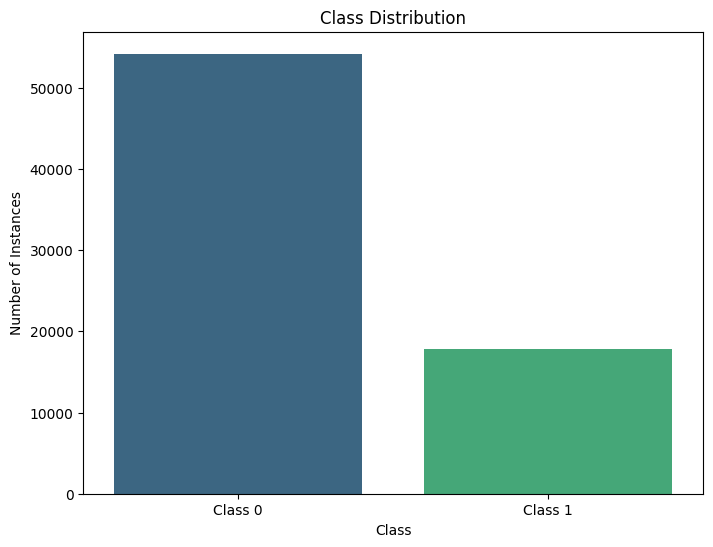

In [221]:
# Count the number of instances for each class
class_counts = data['class'].value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')
plt.xticks(ticks=class_counts.index, labels=[f'Class {i}' for i in class_counts.index])
plt.show()

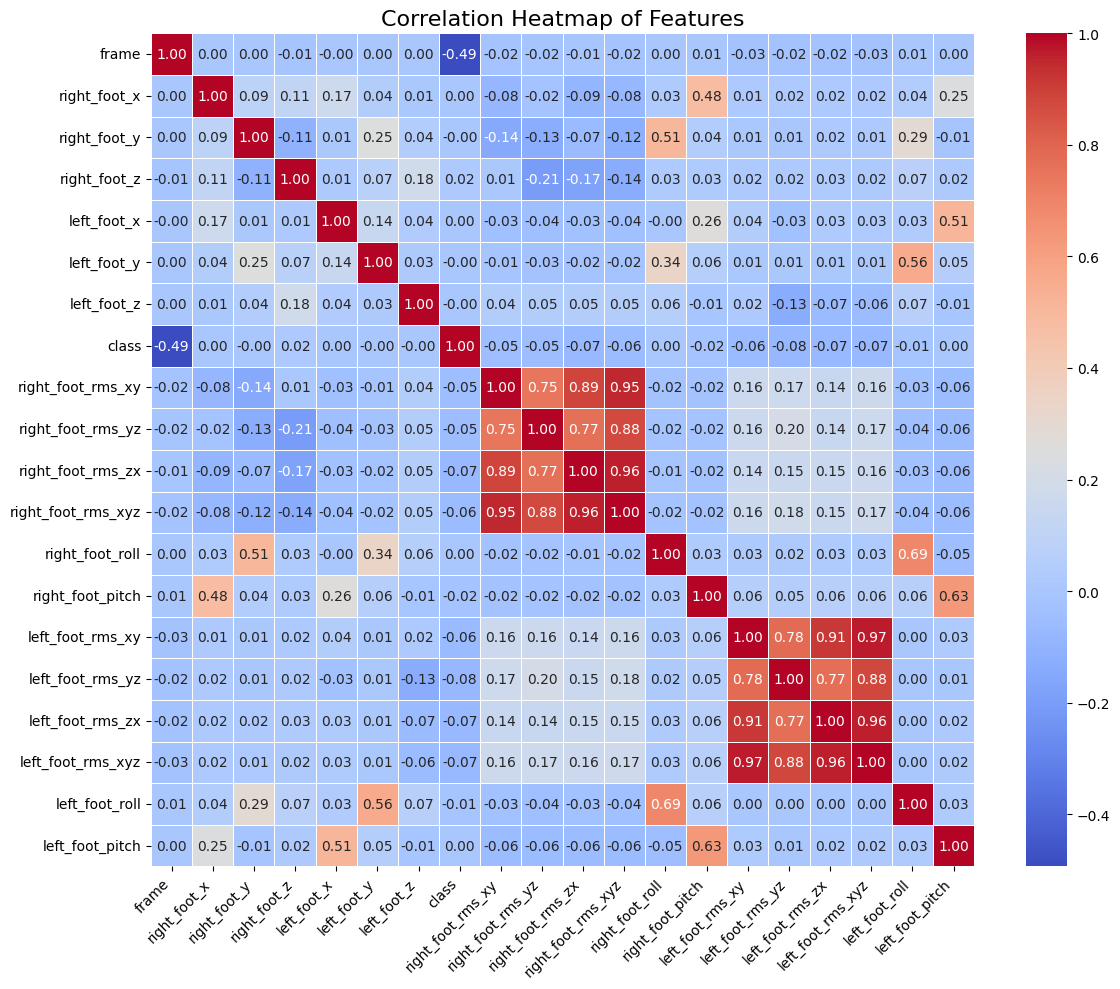

In [222]:
def draw_correlation_heatmap(df):
    """
    Draws a correlation heatmap for the provided DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data with features.

    Returns:
        None: Displays a correlation heatmap.
    """
    # Compute correlation matrix
    corr_matrix = df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))

    # Draw the heatmap with 'seaborn'
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

    # Add titles and labels
    plt.title("Correlation Heatmap of Features", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Show plot
    plt.tight_layout()
    plt.show()

# Now you can call the function to draw the correlation heatmap for your data
draw_correlation_heatmap(data)

In [223]:
# Step 3: Data Pre-processing and Feature Computation

def compute_statistical_features(df, feature_columns, window_size=60):
    """
    Computes statistical features for each window of data.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        feature_columns (list): List of columns to compute features on.
        window_size (int): Size of the window (number of frames).

    Returns:
        pd.DataFrame: DataFrame with statistical features and labels.
    """
    num_samples = df.shape[0]
    num_windows = num_samples // window_size

    # Initialize Lists to Store Features and Labels
    feature_list = []
    label_list = []

    # Loop Over Each Window to Compute Statistical Features
    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        window_data = df.iloc[start_idx:end_idx]
        features = []
        # Compute Features for Each Column
        for col in feature_columns:
            col_data = window_data[col]
            mean = col_data.mean()
            std = col_data.std()
            min_val = col_data.min()
            max_val = col_data.max()
            auc = simps(col_data, dx=1)
            peaks, _ = find_peaks(col_data)
            num_peaks = len(peaks)
            features.extend([mean, std, min_val, max_val, auc, num_peaks])
        # Append Class Label
        label = window_data['class'].iloc[0]
        label_list.append(label)
        feature_list.append(features)

    # Create Feature Names
    feature_names = []
    for col in feature_columns:
        feature_names.extend([
            f'{col}_mean',
            f'{col}_std',
            f'{col}_min',
            f'{col}_max',
            f'{col}_auc',
            f'{col}_num_peaks'
        ])

    # Create a DataFrame with Features and Labels
    features_df = pd.DataFrame(feature_list, columns=feature_names)
    features_df['class'] = label_list

    return features_df

# Define the Columns to Compute Features On (Columns 2-19)
feature_columns = [
    f'{column_set1_name}_x', f'{column_set1_name}_y', f'{column_set1_name}_z',
    f'{column_set2_name}_x', f'{column_set2_name}_y', f'{column_set2_name}_z',
    f'{column_set1_name}_rms_xy', f'{column_set1_name}_rms_yz', f'{column_set1_name}_rms_zx', f'{column_set1_name}_rms_xyz', f'{column_set1_name}_roll', f'{column_set1_name}_pitch',
    f'{column_set2_name}_rms_xy', f'{column_set2_name}_rms_yz', f'{column_set2_name}_rms_zx', f'{column_set2_name}_rms_xyz', f'{column_set2_name}_roll', f'{column_set2_name}_pitch',
]

# Compute Statistical Features
features_df = compute_statistical_features(data, feature_columns)
features_df.to_csv('/content/drive/MyDrive/COS40007/Portfolio2/Dataset/features.csv', index=False)
print(f"Features DataFrame shape: {features_df.shape}\n")

<ipython-input-223-ac24e52ab5ec>:35: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  auc = simps(col_data, dx=1)


Features DataFrame shape: (1201, 109)



<ipython-input-224-333230707539>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


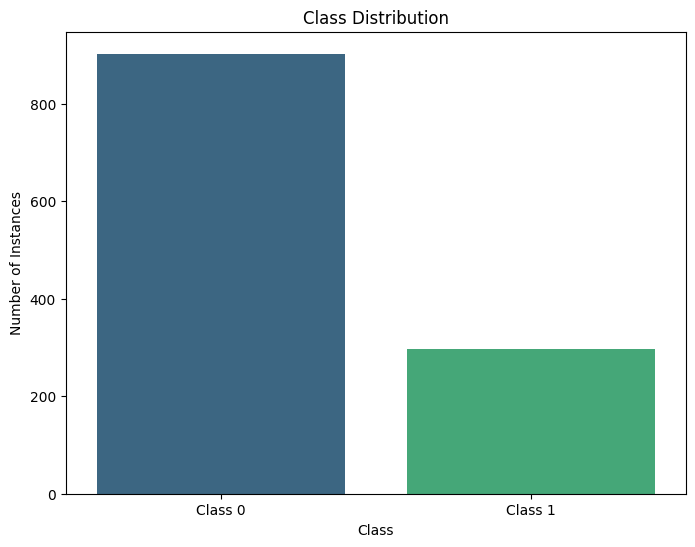

In [224]:
# Count the number of instances for each class
class_counts = features_df['class'].value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')
plt.xticks(ticks=class_counts.index, labels=[f'Class {i}' for i in class_counts.index])
plt.show()

In [225]:
# Step 4: Training and Evaluation

def evaluate_model(model, X_test, y_test, cv_folds=10):
    """
    Evaluates the model using accuracy score and cross-validation.

    Parameters:
        model: Trained machine learning model.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test labels.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: Dictionary containing accuracy scores.
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_test, y_test, cv=cv_folds)
    return {
        'accuracy': accuracy,
        'cross_val_mean': cv_scores.mean(),
        'cross_val_std': cv_scores.std()
    }

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, cv_folds=10):
    """
    Trains the model and evaluates it on the test set and using cross-validation.

    Parameters:
        model: Machine learning model.
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Test features.
        y_train (pd.Series): Training labels.
        y_test (pd.Series): Test labels.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: Dictionary containing the trained model and evaluation metrics.
    """
    # Train the model
    model.fit(X_train, y_train)

    # Evaluate on test set
    evaluation = evaluate_model(model, X_test, y_test, cv_folds=cv_folds)

    return {
        'model': model,
        'accuracy': evaluation['accuracy'],
        'cross_val_mean': evaluation['cross_val_mean'],
        'cross_val_std': evaluation['cross_val_std']
    }

def hyperparameter_tuning(model, param_grid, X_train, y_train, cv_folds=5):
    """
    Performs hyperparameter tuning using GridSearchCV.

    Parameters:
        model: Machine learning model.
        param_grid (dict): Dictionary with parameters names as keys and lists of parameter settings to try as values.
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training labels.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        GridSearchCV: GridSearchCV object after fitting.
    """
    grid_search = GridSearchCV(model, param_grid, cv=cv_folds)
    grid_search.fit(X_train, y_train)
    return grid_search

def select_top_k_features(X, y, k=100):
    """
    Selects top k features using ANOVA F-test.

    Parameters:
        X (pd.DataFrame): Feature DataFrame.
        y (pd.Series): Labels.
        k (int): Number of top features to select.

    Returns:
        tuple: (X_new, selected_feature_names)
    """
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support(indices=True)]
    return X_new, selected_features

def apply_pca(X, n_components=10):
    """
    Applies PCA to reduce dimensionality.

    Parameters:
        X (pd.DataFrame or np.ndarray): Feature data.
        n_components (int): Number of principal components to keep.

    Returns:
        np.ndarray: Transformed data.
    """
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

In [226]:
# Split Data into Features and Labels
X = features_df.drop('class', axis=1)
y = features_df['class']

# Standardize the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Setting 1: Train-Test Split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)

# Initialize SVM Classifier
svm = SVC()

# Train and Evaluate SVM Classifier
svm_results = train_and_evaluate_model(svm, X_train, X_test, y_train, y_test)
print(f"SVM Accuracy (Train-Test Split): {svm_results['accuracy']:.4f}")
print(f"SVM Cross-validation Mean Score: {svm_results['cross_val_mean']:.4f} ± {svm_results['cross_val_std']:.4f}")

SVM Accuracy (Train-Test Split): 0.9114
SVM Cross-validation Mean Score: 0.8920 ± 0.0382


In [227]:
# Setting 2: Hyperparameter Tuning with Train-Test Split

# Define Parameter Grid for Hyperparameter Tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

# Hyperparameter Tuning with Train-Test Split
svm_tuned = hyperparameter_tuning(SVC(), param_grid, X_train, y_train)

# Evaluate the Tuned Model
svm_tuned_results = train_and_evaluate_model(svm_tuned.best_estimator_, X_train, X_test, y_train, y_test)
print(f"Tuned SVM Accuracy (Train-Test Split): {svm_tuned_results['accuracy']:.4f}")
print(f"Tuned SVM Cross-validation Mean Score: {svm_tuned_results['cross_val_mean']:.4f} ± {svm_tuned_results['cross_val_std']:.4f}")

Tuned SVM Accuracy (Train-Test Split): 0.9307
Tuned SVM Cross-validation Mean Score: 0.9113 ± 0.0462


In [228]:
# Setting 3: Top 10 Best Features with Hyperparameter Tuning

# Select Top 10 Features
X_new, selected_features = select_top_k_features(pd.DataFrame(X_scaled, columns=X.columns), y, k=100)
print("Selected features:", selected_features)

# Split the Data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=0.3, random_state=1)

# Evaluate the Tuned Model
svm_tuned_new_results = train_and_evaluate_model(svm_tuned.best_estimator_, X_train_new, X_test_new, y_train_new, y_test_new)
print(f"Tuned SVM with Top 10 Features Accuracy (Train-Test Split): {svm_tuned_new_results['accuracy']:.4f}")
print(f"Tuned SVM with Top 10 Features Cross-validation Mean Score: {svm_tuned_new_results['cross_val_mean']:.4f} ± {svm_tuned_new_results['cross_val_std']:.4f}")

Selected features: Index(['right_foot_x_std', 'right_foot_x_min', 'right_foot_x_max',
       'right_foot_x_num_peaks', 'right_foot_y_mean', 'right_foot_y_std',
       'right_foot_y_min', 'right_foot_y_max', 'right_foot_y_auc',
       'right_foot_y_num_peaks', 'right_foot_z_mean', 'right_foot_z_std',
       'right_foot_z_min', 'right_foot_z_max', 'right_foot_z_auc',
       'right_foot_z_num_peaks', 'left_foot_x_mean', 'left_foot_x_std',
       'left_foot_x_min', 'left_foot_x_max', 'left_foot_x_num_peaks',
       'left_foot_y_std', 'left_foot_y_min', 'left_foot_y_max',
       'left_foot_y_auc', 'left_foot_y_num_peaks', 'left_foot_z_mean',
       'left_foot_z_std', 'left_foot_z_min', 'left_foot_z_max',
       'left_foot_z_auc', 'left_foot_z_num_peaks', 'right_foot_rms_xy_mean',
       'right_foot_rms_xy_std', 'right_foot_rms_xy_min',
       'right_foot_rms_xy_max', 'right_foot_rms_xy_auc',
       'right_foot_rms_xy_num_peaks', 'right_foot_rms_yz_mean',
       'right_foot_rms_yz_std', 'rig

In [229]:
# Setting 4: PCA with Hyperparameter Tuning

# Apply PCA
X_pca = apply_pca(X_scaled, n_components=10)

# Split the Data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.3, random_state=1)

# Evaluate the Tuned Model
svm_tuned_pca_results = train_and_evaluate_model(svm_tuned.best_estimator_, X_train_pca, X_test_pca, y_train_pca, y_test_pca)
print(f"Tuned SVM with PCA Accuracy (Train-Test Split): {svm_tuned_pca_results['accuracy']}")
print(f"Tuned SVM with PCA Cross-validation Mean Score: {svm_tuned_pca_results['cross_val_mean']} ± {svm_tuned_pca_results['cross_val_std']:.4f}")

Tuned SVM with PCA Accuracy (Train-Test Split): 0.8975069252077562
Tuned SVM with PCA Cross-validation Mean Score: 0.891966966966967 ± 0.0382


In [230]:
# Create Summary Table of SVM Results
svm_results_list = [
    {'Model': 'SVM (Train-Test Split)', 'Accuracy': svm_results['accuracy'], 'CrossValMean': svm_results['cross_val_mean']},
    {'Model': 'Tuned SVM (Train-Test Split)', 'Accuracy': svm_tuned_results['accuracy'], 'CrossValMean': svm_tuned_results['cross_val_mean']},
    {'Model': 'Tuned SVM with Top 10 Features', 'Accuracy': svm_tuned_new_results['accuracy'], 'CrossValMean': svm_tuned_new_results['cross_val_mean']},
    {'Model': 'Tuned SVM with PCA', 'Accuracy': svm_tuned_pca_results['accuracy'], 'CrossValMean': svm_tuned_pca_results['cross_val_mean']}
]

svm_results_df = pd.DataFrame(svm_results_list)

# Define the results directory
results_dir = '/content/drive/MyDrive/COS40007/Portfolio2/Results'
os.makedirs(results_dir, exist_ok=True)

# Save the results to a CSV file
results_csv_path = os.path.join(results_dir, 'results.csv')
svm_results_df.to_csv(results_csv_path, index=False)
print("Summary of SVM Results:")
print(svm_results_df)

Summary of SVM Results:
                            Model  Accuracy  CrossValMean
0          SVM (Train-Test Split)  0.911357      0.891967
1    Tuned SVM (Train-Test Split)  0.930748      0.911336
2  Tuned SVM with Top 10 Features  0.922438      0.916892
3              Tuned SVM with PCA  0.897507      0.891967


In [231]:
# Train SGD, RandomForest, and MLP Classifiers

# Initialize Other Classifiers
sgd = SGDClassifier(random_state=1, max_iter=1000)
rf = RandomForestClassifier(random_state=1)
mlp = MLPClassifier(random_state=1, max_iter=1000)

# Train and Evaluate SGD Classifier
sgd_results = train_and_evaluate_model(sgd, X_train, X_test, y_train, y_test)
print(f"SGD Accuracy (Train-Test Split): {sgd_results['accuracy']:.4f}")
print(f"SGD Cross-validation Mean Score: {sgd_results['cross_val_mean']:.4f} ± {sgd_results['cross_val_std']:.4f}")

# Train and Evaluate Random Forest Classifier
rf_results = train_and_evaluate_model(rf, X_train, X_test, y_train, y_test)
print(f"Random Forest Accuracy (Train-Test Split): {rf_results['accuracy']:.4f}")
print(f"Random Forest Cross-validation Mean Score: {rf_results['cross_val_mean']:.4f} ± {rf_results['cross_val_std']:.4f}")

# Train and Evaluate MLP Classifier
mlp_results = train_and_evaluate_model(mlp, X_train, X_test, y_train, y_test)
print(f"MLP Accuracy (Train-Test Split): {mlp_results['accuracy']:.4f}")
print(f"MLP Cross-validation Mean Score: {mlp_results['cross_val_mean']:.4f} ± {mlp_results['cross_val_std']:.4f}")

SGD Accuracy (Train-Test Split): 0.7867
SGD Cross-validation Mean Score: 0.8697 ± 0.0747
Random Forest Accuracy (Train-Test Split): 0.8975
Random Forest Cross-validation Mean Score: 0.8947 ± 0.0408
MLP Accuracy (Train-Test Split): 0.9363
MLP Cross-validation Mean Score: 0.8919 ± 0.0457


In [232]:
# Create Outcome Table for Other ML Models
other_models_results_list = [
    {'Model': 'SGD (Train-Test Split)', 'Accuracy': sgd_results['accuracy'], 'CrossValMean': sgd_results['cross_val_mean']},
    {'Model': 'Random Forest (Train-Test Split)', 'Accuracy': rf_results['accuracy'], 'CrossValMean': rf_results['cross_val_mean']},
    {'Model': 'MLP (Train-Test Split)', 'Accuracy': mlp_results['accuracy'], 'CrossValMean': mlp_results['cross_val_mean']}
]

other_models_results_df = pd.DataFrame(other_models_results_list)
# Define the results directory
results_dir = '/content/drive/MyDrive/COS40007/Portfolio2/Results'
os.makedirs(results_dir, exist_ok=True)

# Save the results to a CSV file
results_csv_path = os.path.join(results_dir, 'results_ml.csv')
other_models_results_df.to_csv(results_csv_path, index=False)
print("Summary of Other ML Models:")
print(other_models_results_df)

Summary of Other ML Models:
                              Model  Accuracy  CrossValMean
0            SGD (Train-Test Split)  0.786704      0.869670
1  Random Forest (Train-Test Split)  0.897507      0.894745
2            MLP (Train-Test Split)  0.936288      0.891892
